In [2]:
!pip install wfdb
!pip install skorch
#!pip install librosa

  Obtaining dependency information for skorch from https://files.pythonhosted.org/packages/f3/2f/2e5df7adb64d8457ea4104bcdfe4265251825d17bd3752f2de4d364723e8/skorch-1.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 11.7 MB/s eta 0:00:00


In [3]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as mat
import cv2
from scipy.fft import fft
import scipy.signal as sg
import pickle
#from pathlib import Pat
#import pyswarms as ps
import scipy.signal as sg
import wfdb
import joblib
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Initializer, LRScheduler, TensorBoard
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from torch.backends import cudnn
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from collections import Counter

# Progressive Moving Average

In [4]:
from sklearn.cluster import KMeans
import warnings
from PIL import Image


warnings.filterwarnings("ignore")

def moving_average(signal, window):
    # create the window weights
    weights = np.repeat(1.0, window) / window            
    # use numpy's convolve function to perform the moving average
    ma = np.convolve(signal, weights, 'valid')
    return ma

def pmat(signal,max_window,direction):
    N=len(signal) # padding
    M=np.ndarray(shape=(max_window,N))
    padded_signal=np.concatenate((np.ones(N)*signal[0],signal,np.ones(N)*signal[-1]))    
    for w in range(1,max_window+1):
        if direction=='Left':
            M[w-1]=moving_average(padded_signal[N-w:2*N-1], window=w) 
        elif direction=='Right':
            M[w-1]=moving_average(padded_signal[N:2*N-1+w], window=w)             
    return M

In [5]:
invalid_anns = ['|', '~', '!', '+', '[', ']', '"', 'x', 'f', 'Q', 's', 'T', 'n', 'B']
PhysioBank = {
        "N": 0, "L": 0, "R": 0, "e": 0, "j": 0,  # N
        "A": 1, "a": 1, "S": 1, "J": 1,  # S
        "V": 2, "E": 2,  # V
        "F": 3,  # F
        "/": 4, # Peaced beats        
}

### MIT-BIH database

In [6]:
records_mit_train = ['101', '106', '109', '112', '114', '115', '116', '118', '119', '122', '124', '201', '203', '205', '207', '208', '215', '220','223', '230', '232', '222']
records_mit_test  = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '209', '210', '212', '213','214', '219', '221', '228', '231', '233', '234']

path_str_mit = '/kaggle/input/mit-bih-arrhhythmia/mit-bih-arrhythmia-database-1.0.0'

#### INCART Database

In [9]:
records_incart_train = ['I03', 'I04',  'I05', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I16', 'I17', 'I18', 'I19', 'I25', 'I26', 'I27', 'I28', 'I33', 'I34', 'I35', 'I36', 'I37', 'I44', 'I45', 'I46', 'I47', 'I48', 'I54', 'I55', 'I56', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I75', 'I42', 'I43', 'I62', 'I63', 'I64', 'I06', 'I07']
records_incart_test =  ['I01', 'I02', 'I15', 'I20', 'I21', 'I22', 'I23', 'I24', 'I29', 'I30', 'I31', 'I32', 'I38', 'I39', 'I40', 'I41', 'I49', 'I50', 'I51', 'I52', 'I53', 'I57', 'I58', 'I59', 'I60', 'I61', 'I65', 'I66', 'I67']
path_str_incart = '/kaggle/input/st-petersburgincart-12-lead-1-0-0/files'

In [7]:
import scipy.signal as sg
import wfdb


def prepare_scaled_records(records, database, sampling_rate, path_str):
    scaled_signals = []
    r_peak_list = []
    ann_list = []
    for record in records:
        if database=='stt':
            tol = 0.1
            chanel_number = record[1]
            record = record[0]            
            ecg = wfdb.rdrecord(f'{path_str}/{record}').p_signal[:, chanel_number]
        else:
            tol = 0.05
            ecg = wfdb.rdrecord(f'{path_str}/{record}').p_signal[:, 0 if record!='114' else 1] # record 114 mit-bih is inversed
            
        anns = wfdb.rdann(f'{path_str}/{record}', extension='atr')
        r_peaks, annotations = anns.sample, anns.symbol                                        
        
        baseline = sg.medfilt(sg.medfilt(ecg, int(0.2 * sampling_rate) - 1), int(0.6 * sampling_rate) - 1)
        
        filtered_signal = ecg - baseline
        
        
        scaled_signal = filtered_signal        
        scaled_signals.append(scaled_signal)
        
        # align r-peaks
        newR = []
        for r_peak in r_peaks:
            r_left = np.maximum(r_peak - int(tol * sampling_rate), 0)
            r_right = np.minimum(r_peak + int(tol * sampling_rate), len(scaled_signal))
            newR.append(r_left + np.argmax(scaled_signal[r_left:r_right]))
        r_peaks = np.array(newR, dtype="int")
        
        r_peak_list.append(r_peaks)        
        ann_list.append(annotations) 
    return scaled_signals, r_peak_list, ann_list

##### MIT-BIH

In [8]:
# Used for Exp.1
# The records of MIT-BIH will be regrouped for training for Experiments 3 and 4
scaled_signals1_mit, r_peak_list1_mit, ann_list1_mit = prepare_scaled_records(records_mit_train,'mit', 360, path_str_mit)
scaled_signals2_mit, r_peak_list2_mit, ann_list2_mit = prepare_scaled_records(records_mit_test, 'mit', 360, path_str_mit)

##### INCART signals

In [10]:
# Used for Exp.2
# Regourped for Exp.3 and Exp.5
scaled_signals1_incart, r_peak_list1_incart, ann_list1_incart = prepare_scaled_records(records_incart_train,'incart', 274, path_str_incart)
scaled_signals2_incart, r_peak_list2_incart, ann_list2_incart = prepare_scaled_records(records_incart_test,'incart', 274, path_str_incart)

##### ST european signals

In [9]:
# Extract the ECG recored using MLII leads
path_str_stt = '/kaggle/input/european-st-t/european-st-t-database-1.0.0'
mlii_records_stt = []
with open(f'{path_str_stt}/RECORDS', 'r') as file:    
    for record_name in file.readlines():
        record_name=record_name.replace('\n','')
        with open(f'{path_str_stt}/{record_name}.hea') as file_header:
            for line_number, line in enumerate(file_header, start=1):
                if 'MLIII' in line:
                    # ('e0103', 1) are the record name and the channel of the mlii lead
                    mlii_records_stt.append((record_name, line_number-2))
                    break
            file_header.close()
    file.close()

In [10]:
# Used for test Exp.4
scaled_signals1_stt, r_peak_list1_stt, ann_list1_stt = prepare_scaled_records(mlii_records_stt,'stt', 250, path_str_stt)

#### Used to save the prepared Images obtained by PMAT

In [27]:
from pathlib import Path
Path('/kaggle/working/dataset/mit/pmat/train').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/dataset/mit/pmat/test').mkdir(parents=True, exist_ok=True)

In [12]:
from pathlib import Path
Path('/kaggle/working/dataset/stt/pmat/train').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/dataset/stt/pmat/test').mkdir(parents=True, exist_ok=True)

In [15]:
from pathlib import Path
Path('/kaggle/working/dataset/incart/pmat/train').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/dataset/incart/pmat/test').mkdir(parents=True, exist_ok=True)

In [13]:
def get_peaks_ecg(ecg, rpeak, rr_avg, rr_next, sampling_rate):    
    b1 = min(rpeak + int(sampling_rate*0.026), len(ecg)-1)
    b2 = max(0, rpeak-int(sampling_rate*0.026))

    sp = ecg[rpeak:b1].argmin()    
    speak = rpeak + sp
    speak = rpeak if speak>=len(ecg) else speak
    
    qp = ecg[b2:rpeak].argmin() if b2<rpeak else rpeak
    qpeak = rpeak-int(sampling_rate*0.026)+qp
    qpeak = 0 if qpeak<0 else qpeak

    p_start = max(0, qpeak - int(rr_avg/4))    
    p_end = qpeak
    if p_start == p_end:
        ppeak = rpeak
    elif p_start>p_end:
        t = p_start
        p_start = p_end
        p_end = t
        if len(ecg[p_start:p_end])==0:
            print(p_start,p_end,rpeak,qpeak)
        ppeak = p_start + ecg[p_start:p_end].argmax()
    else:        
        ppeak = p_start + ecg[p_start:p_end].argmax()
        if len(ecg[p_start:p_end])==0:
            pass
            #print(p_start,p_end,rpeak)
        
    t_start = speak + int(sampling_rate*0.166) # 0.166 ms    
    t_end = min(rpeak + int((rr_next)/2), len(ecg))
    tpeak = t_start + ecg[t_start:t_end].argmax() if t_start<t_end else t_start
    tpeak = tpeak if tpeak < len(ecg) else rpeak
    return ppeak, qpeak, rpeak, speak, tpeak

In [14]:
from scipy.stats import skew, kurtosis, median_abs_deviation, skewtest, kurtosistest, fligner, shapiro, power_divergence, tmean
from scipy.signal import welch, periodogram

def getXY(scaled_signals, r_peak_list, ann_list, database, sampling_rate, train): 
    wavelet = "gaus4"  # mexh, morl, gaus8, gaus4
    scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, 80, 1)    
    
    count = 0
    x1, y = [], []
    x2 = []
    
    for i in range(len(scaled_signals)):
        
        # needed for extract limited beats from ST-T database
        counter_beats = {0:0,1:0,2:0}
        scaled_ecg = scaled_signals[i]         
        r_peaks = r_peak_list[i]
        anns = ann_list[i]        
        
        NP = len(scaled_ecg)
                
        avg_rri = np.mean(np.diff(r_peaks))        
        
        all_peaks = [get_peaks_ecg(scaled_ecg, rpeak=r_peaks[k], 
                           rr_avg=r_peaks[k]-r_peaks[k-1] if k>0 and anns[k-1] not in invalid_anns else avg_rri, 
                           rr_next=r_peaks[k+1]-r_peaks[k] if k+1<len(r_peaks) and anns[k+1] not in invalid_anns else avg_rri, 
                           sampling_rate=sampling_rate) for k in range(len(r_peaks))]

        # Hand craft features
        valid_peaks = [all_peaks[k] for k in range(1,len(r_peaks)-1) if anns[k-1] not in invalid_anns and anns[k] not in invalid_anns and anns[k+1] not in invalid_anns]               
        avg_RT = np.mean([peaks[4]-peaks[2] for peaks in valid_peaks])
        avg_PR = np.mean([peaks[2]-peaks[0] for peaks in valid_peaks])
        avg_SQ = np.mean([peaks[3]-peaks[1] for peaks in valid_peaks])
        avg_TQ = np.mean([all_peaks[k][1]-all_peaks[k-1][-1] for k in range(1,len(all_peaks)) if anns[k] not in invalid_anns and anns[k-1] not in invalid_anns])
        avg_TP = np.mean([all_peaks[k][0]-all_peaks[k-1][-1] for k in range(1,len(all_peaks)) if anns[k] not in invalid_anns and anns[k-1] not in invalid_anns])
        avg_P = np.mean([peaks[0] for peaks in valid_peaks])
        
        # For dynamic permutating beteween heatbeats
        m_current = []

        for k in range(len(r_peaks)):
            #skipp 1st and last rpeak
            if k==0 or k == len(r_peaks)-1:
                continue
            
            ppeak_prev, qpeak_prev, r_prev, speak_prev, tpeak_prev = all_peaks[k-1]
            ppeak, qpeak, _, speak, tpeak = all_peaks[k]            
            ppeak_next, qpeak_next, r_next, speak_next, tpeak_next = all_peaks[k+1]

            r, ann = r_peaks[k], anns[k]
            
            if ann=='J':
                continue
            
            if ann in invalid_anns or ann not in PhysioBank.keys():
                continue
            
            # continue if the previous beat is unknown
            if anns[k-1] in invalid_anns or anns[k+1] in invalid_anns:
                continue
            
            if r_peaks[k + 1] - r_peaks[k] == 0 or r_peaks[k] - r_peaks[k-1]==0:
                continue
            
            # continue if this r_peak is negative            
            if r_peaks[i]<0:
                continue
            
            if r<before or r+after >= NP:
                pass            
            
            if r_prev<before or NP - r_next<after:
                continue                                                     
            
            if count % 20000 ==0:
                print(f'{count} done')              
            
            label = PhysioBank[ann] 
            label_prev = PhysioBank[anns[k-1]]
            if label == 3:
                continue              
                
            counter_beats[label]+=1
            if database=='stt' and label==0 and counter_beats[0]>500:                
                continue                                                   
            
            #Calculate wave duration
            PR, RT, SQ = r-ppeak, tpeak-r, speak-qpeak                                                                        
                                    
            # The heartbeat that will be classified, and its previous and next
            heartbeat = scaled_ecg[r-before:r+after]                        
            heartbeat_prev = scaled_ecg[r_prev-before:r_prev+after]            
            heartbeat_next = scaled_ecg[r_next-before:r_next+after]
                        

            # Skip if all = 0
            if heartbeat.any()==0:
                print(i)
                continue 
                
            # statistics
            sktest = skewtest(heartbeat)            
            #shapirotest = shapiro(heartbeat)                       
            
            subset = 'train' if train else 'test'                        
            path_current = f'/kaggle/working/dataset/{database}/pmat/{subset}/x1_{i}_{r}.pt' 
            
            # Scale the heartbeat            
            heartbeat = (heartbeat-heartbeat.min())/(heartbeat.max()-heartbeat.min())                                    
            heartbeat_prev = (heartbeat_prev-heartbeat_prev.min())/(heartbeat_prev.max()-heartbeat_prev.min())                         
            heartbeat_next = (heartbeat_next-heartbeat_next.min())/(heartbeat_next.max()-heartbeat_next.min())                                                                                                                                               
                                         
            if len(m_current)==0:
                m_prev = pmat(heartbeat_prev, max_window=100, direction='Left') 
                m_prev = cv2.resize(m_prev, (120, 120))
                
                m_current = pmat(heartbeat, max_window=100, direction='Left') 
                m_current = cv2.resize(m_current, (120, 120)) 
            else:
                m_prev=m_current
                m_current=m_next
                        
            m_next = pmat(heartbeat_next, max_window=100, direction='Left') 
            m_next = cv2.resize(m_next, (120, 120))                                    
            
            m = torch.tensor(np.array([m_prev, m_current, m_next])).reshape([3,120, 120]).float()
            torch.save(m, path_current)
            
            # OR Take only the current heartbeat
            '''
            m_current = pmat(heartbeat, max_window=100, direction='Left')
           
            m_current = cv2.resize(m_current, (120, 120))
            m = torch.tensor(np.array([m_current])).reshape([1,120, 120]).float()
            torch.save(m, path_current)  
            '''
            
            a = np.maximum(k - 18, 0)
            b = np.maximum(a + 18, k + 1)
            avg_rri_local = np.mean(np.diff(r_peaks[a:b]))
            coef = sampling_rate/360
            input_2 = np.array([
                (r_peaks[k] - r_peaks[k - 1]) / avg_rri,  # previous RR Interval
                (r_peaks[k + 1] - r_peaks[k]) / avg_rri,  # post RR Interval
                (r_peaks[k] - r_peaks[k - 1]) / (r_peaks[k + 1] - r_peaks[k]),  # ratio RR Interval                
                avg_rri_local / avg_rri,  # local RR Interval
            ])            
            
            x1.append(path_current)
            x2.append(input_2)
            y.append(label)
            count +=1
    print(f'{count} done')
    return x1, x2, y

#### Prepare X, Y for MIT-BIH

In [54]:
# Exp.1
before, after = 110, 120
x1_train_mit, x2_train_mit, y_train_mit = getXY(scaled_signals1_mit, r_peak_list1_mit, ann_list1_mit, 'mit', 360, True)
x1_test_mit, x2_test_mit, y_test_mit = getXY(scaled_signals2_mit, r_peak_list2_mit, ann_list2_mit, 'mit', 360, False)

0 done
20000 done
40000 done
47999 done
0 done
20000 done
40000 done
45882 done


In [19]:
torch.save({'x1':x1_train_mit, 'x2':x2_train_mit, 'y':y_train_mit},'/kaggle/working/dataset/mit/pmat/train/train_infos.pt')
torch.save({'x1':x1_test_mit, 'x2':x2_test_mit, 'y':y_test_mit},'/kaggle/working/dataset/mit/pmat/test/test_infos.pt')

In [15]:
# Needed for perform last 3 experiments
# These data may be used for training and testing
before, after = 90, 100 # MIT
x1_full_mit, x2_full_mit, y_full_mit = getXY(scaled_signals1_mit+scaled_signals2_mit, r_peak_list1_mit+r_peak_list2_mit, ann_list1_mit+ann_list2_mit, 'mit', 360, True)
torch.save({'x1':x1_full_mit, 'x2':x2_full_mit, 'y':y_full_mit},'/kaggle/working/dataset/mit/pmat/train/full_infos.pt')

0 done
20000 done
40000 done
48003 done


#### Prepare X, Y for INCART

In [21]:
# Exp.2
before, after = 70, 75
x1_train_incart, x2_train_incart, y_train_incart = getXY(scaled_signals1_incart, r_peak_list1_incart, ann_list1_incart, 'incart', 360, True)
x1_test_incart, x2_test_incart, y_test_incart = getXY(scaled_signals2_incart, r_peak_list2_incart, ann_list2_incart, 'incart', 360, False)

0 done
20000 done
40000 done
60000 done
80000 done
100000 done
104804 done
0 done
20000 done
40000 done
60000 done
70566 done


In [22]:
# Needed for Exp.2
torch.save({'x1':x1_train_incart, 'x2':x2_train_incart, 'y':y_train_incart},'/kaggle/working/dataset/incart/pmat/train/train_infos.pt')
torch.save({'x1':x1_test_incart, 'x2':x2_test_incart, 'y':y_test_incart},'dataset/incart/pmat/test/test_infos.pt')

In [32]:
# Needed for 3 and 5 experiments
before, after = 70, 75 # INCART
x1_full_incart, x2_full_incart, y_full_incart = getXY(scaled_signals1_incart+scaled_signals2_incart, r_peak_list1_incart+r_peak_list2_incart, ann_list1_incart+ann_list2_incart, 'incart', 274, True)
torch.save({'x1':x1_full_incart, 'x2':x2_full_incart, 'y':y_full_incart},'/kaggle/working/dataset/incart/pmat/train/full_infos.pt')

0 done
20000 done
40000 done
60000 done
80000 done
100000 done
120000 done
140000 done
160000 done
175370 done


#### Prepare X, Y for ST-T

In [16]:
# Needed for Experiment 5
before, after = 62, 70 # ST-T
x1_full_stt, x2_full_stt, y_full_stt = getXY(scaled_signals1_stt, r_peak_list1_stt, ann_list1_stt, 'stt',250, True)
torch.save({'x1':x1_full_stt, 'x2':x2_full_stt, 'y':y_full_stt},'/kaggle/working/dataset/stt/pmat/train/full_infos.pt')

0 done
20000 done
20000 done
20000 done
25256 done


# Customized Dataset

In [17]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.labels = y
        self.X = X  
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):         
        path_x1 = self.X['x1'][idx]        
        x1 = torch.load(path_x1)                    
        x2 = np.array(self.X['x2'][idx])
        y = self.labels[idx]
        return {'x1':x1,'x2':x2}, y

### One of the following is choosed: Exp.1, Exp.2, Exp.3, Exp.4, or Exp.5

In [26]:
# Exp.1
# Train on MIT-BIH training subset 1 and test on MIT-BIH testing subset 2
train_infos = torch.load('/kaggle/working/dataset/mit/pmat/train/train_infos.pt')
test_infos = torch.load('/kaggle/working/dataset/mit/pmat/test/test_infos.pt')

In [27]:
# Exp.2
# Train on INCART training subset 1 and test on INCART testing subset 2
train_infos = torch.load('/kaggle/working/dataset/incart/pmat/train/train_infos.pt')
test_infos = torch.load('/kaggle/working/dataset/incart/pmat/test/test_infos.pt')

In [33]:
# Exp.3
# train on MIT-BIH and test on INCART
train_infos = torch.load('/kaggle/working/dataset/mit/pmat/train/full_infos.pt')
test_infos = torch.load('/kaggle/working/dataset/incart/pmat/train/full_infos.pt')

In [18]:
# Exp.4
# train on MIT-BIH and test on STT
train_infos = torch.load('/kaggle/working/dataset/mit/pmat/train/full_infos.pt')
test_infos = torch.load('/kaggle/working/dataset/stt/pmat/train/full_infos.pt')

In [35]:
# Exp.5
# train on INCART and test on MIT-BIH
train_infos = torch.load('/kaggle/working/dataset/incart/pmat/train/full_infos.pt')
test_infos = torch.load('/kaggle/working/dataset/mit/pmat/train/full_infos.pt')

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X1_train = train_infos['x1']
X2_train = np.array(train_infos['x2']).astype(np.float64)

x2_mean = X2_train.mean()
x2_std = X2_train.std()

X2_train = scaler.fit_transform(X2_train)
X2_train = torch.tensor(X2_train).float()
y_train = train_infos['y']
y_train = np.array(y_train).astype(torch.LongTensor)

train_ds = CustomDataset({'x1':X1_train, 'x2':X2_train}, y_train)

In [20]:
X1_test = test_infos['x1']
X2_test = np.array(test_infos['x2']).astype(np.float64)
X2_test = scaler.transform(X2_test)

X2_test = torch.tensor(X2_test).float()
y_test = test_infos['y']
y_test = np.array(y_test).astype(torch.LongTensor)

test_ds = CustomDataset({'x1':X1_test, 'x2':X2_test}, y_test)

# Net Module

In [21]:
log_dir = "./logs/{}".format('pmat')
shutil.rmtree(log_dir, ignore_errors=True)
    
callbacks = [
        Initializer("[conv|fc]*.weight", fn=torch.nn.init.kaiming_normal_),
        Initializer("[conv|fc]*.bias", fn=partial(torch.nn.init.constant_, val=0.0)),
        LRScheduler(policy=StepLR, step_size=5, gamma=0.1),
        EpochScoring(scoring=make_scorer(f1_score, average="macro"), lower_is_better=False, name="valid_f1"),
        TensorBoard(SummaryWriter(log_dir))
    ]

item = next(iter(train_ds))
L = len(item[0]['x2'])
print(L)

4


In [22]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()        
        self.conv1 = nn.Conv2d(3, 32, (5, 5))
        self.conv2 = nn.Conv2d(32, 64, (5, 5))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pooling1 = nn.MaxPool2d(5)
        self.pooling2 = nn.MaxPool2d(3)
        self.pooling3 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc0 = nn.Linear(128,128)
        self.fc1 = nn.Linear(L,128)    
        self.fc11 = nn.Linear(256,64)
        self.fc2 = nn.Linear(64, 3)
        
    def extract_features(self,x1):
        x1 = F.relu(self.bn1(self.conv1(x1)))
        x1 = self.pooling1(x1)
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = self.pooling2(x1)
        x1 = F.relu(self.bn3(self.conv3(x1)))
        x1 = self.pooling3(x1)
        x1 = x1.view((-1, 128))   
        return x1
    
    def forward(self, **kwarg):
        x2 = kwarg['x2']
        x1 = kwarg['x1']                
        
        x1 = self.extract_features(x1)
        x1 = F.relu(self.fc0(x1))
        x2 = F.relu(self.fc1(x2))        
        x = torch.cat((x1, x2), dim=1)                      
        x = F.relu(self.fc11(x))
        x = self.fc2(x)
        return x

In [23]:
# skorch is extensive package of pytorch for compatible with scikit-learn
net = NeuralNetClassifier(
    MyModule,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.004,
    max_epochs=15,
    batch_size=512,    
    train_split=None, #predefined_split(test_ds),None
    verbose=1,
    device="cuda:0",#"cuda:0","cpu"
    callbacks=callbacks,
    iterator_train__shuffle=True,
    optimizer__weight_decay=0,        
)

cudnn.benchmark = False
cudnn.deterministic = True
torch.manual_seed(0)

In [24]:
net.fit(train_ds, y_train)

  epoch    train_loss      lr      dur
-------  ------------  ------  -------
      1        0.1233  0.0040  64.3070
      2        0.0366  0.0040  47.4206
      3        0.0271  0.0040  28.7490
      4        0.0237  0.0040  28.2459
      5        0.0226  0.0040  28.5451
      6        0.0151  0.0004  28.2487
      7        0.0129  0.0004  28.4302
      8        0.0119  0.0004  28.2741
      9        0.0115  0.0004  28.6549
     10        0.0108  0.0004  28.3304
     11        0.0097  0.0000  28.5730
     12        0.0096  0.0000  28.4163
     13        0.0096  0.0000  29.3268
     14        0.0094  0.0000  28.3361
     15        0.0094  0.0000  28.5827


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (pooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pooling3): AdaptiveMaxPool2d(output_size=(1, 1))
    (fc0): Linear(in_features=128, out_features=128, bias=True)
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc11): Linear(in_features=256, out_features=64, bias=True)
    (fc2): Linear(in_features

In [ ]:
with torch.no_grad():
    y_true, y_pred = y_test, net.predict(test_ds)
    y_true = np.array(y_true).astype(np.int64)
    y_pred = np.array(y_pred).astype(np.int64)
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
import seaborn as sns
classes_ = ['N', 'S', 'V']
N = 3
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(cf_matrix.flatten()[i]/np.sum(cf_matrix[int(i/N)])) for i in range(N*N)]
labels_ = [f'{y}' for x,y in zip(group_percentages, group_counts)]
#labels_ = [f'{y}' for x,y in zip(group_counts, group_percentages)]
labels_ = np.asarray(labels_).reshape(N,N)
fig, ax = plt.subplots(figsize=(4,3))

sns.heatmap(cf_matrix, 
            vmin=0, 
            vmax=420,
            annot=labels_, 
            linewidths=.5, 
            ax=ax, 
            fmt='', 
            cmap='crest', # Blues, RdBu_r, BuPu, crest
            annot_kws={"weight": "bold"},
            xticklabels=classes_, 
            yticklabels=classes_
           ).set(title='Training on MIT-BIH Testing on STT')

### ROC and AUC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
with torch.no_grad():
    y_proba = net.predict_proba(test_ds)  # Probabilities for each class

# Convert true labels to one-hot encoding for multiclass ROC calculation
num_classes = y_proba.shape[1]
y_true_onehot = np.eye(num_classes)[y_true]

# Calculate ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Gradient-weighted Class Activation Mapping

In [49]:
class GradCam:
    def __init__(self, skorch_net, target_layer):
        """
        Initialize Grad-CAM with the skorch NeuralNetClassifier and the target layer.
        """
        self.net = skorch_net.module_  # Access the PyTorch model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_feature_maps)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_feature_maps(self, module, input, output):
        """
        Save the feature maps during the forward pass.
        """
        self.feature_maps = output

    def _save_gradients(self, module, grad_input, grad_output):
        """
        Save the gradients during the backward pass.
        """
        self.gradients = grad_output[0]

    def generate_heatmap(self, x, class_idx=None):
        """
        Generate Grad-CAM heatmap.
        """
        self.net.zero_grad()  # Reset gradients on the underlying PyTorch model
        output = self.net(**x)  # Pass input through the PyTorch model

        if class_idx is None:
            class_idx = torch.argmax(output)

        # Backpropagate to get gradients
        class_score = output[:, class_idx]
        class_score.backward()

        # Compute Grad-CAM
        gradients = self.gradients.detach()
        feature_maps = self.feature_maps.detach()
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
                
        cam = torch.sum(weights * feature_maps, dim=1).squeeze() 
        
        if F.relu(cam).sum()!=0:
            cam = F.relu(cam)  # Apply ReLU to focus on positive contributions 
        else:
            cam = 1-cam
        #plt.imshow(cam.to('cpu'))
        
        # Normalize heatmap        
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

    @staticmethod
    def overlay_heatmap(image, heatmap, alpha, cmap='jet'):
        """
        Overlay the Grad-CAM heatmap on the original image.
        """
        import cv2
    
        # Convert heatmap to numpy array
        heatmap = heatmap.cpu().numpy()        
        image = image.squeeze().cpu().numpy()  
        # Resize heatmap to match the input image dimensions
        #heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))  # Resize to (H, W)
        heatmap_resized = cv2.resize(heatmap, (120, 120))  # Resize to (H, W)                
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_resized = np.where(heatmap_resized>100,heatmap_resized,heatmap_resized-10)
        
        #heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Apply a colormap
        
        a, b = image.min(), image.max()        
        #heatmap_resized = normalize_tensor(heatmap_resized, a, b)                        
        # Normalize and convert image to range 0-255
        if len(image.shape) == 2:  # If grayscale
            #print('GRAYSCALE')
            image = np.uint8(255 * (image - image.min()) / (image.max() - image.min()))
            #image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel (BGR)
        else:  # If RGB or multi-channel
            image = np.uint8(255 * (image - image.min()) / (image.max() - image.min()))
    
        # Blend the heatmap with the original image
                    
        #plt.imshow(heatmap_colored)
        #overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)                
        return image + heatmap_resized*alpha

In [ ]:
def read_beat(path):
    path_splitted = path.split('_')
    n, r = int(path_splitted[-2]), int(path_splitted[-1].split('.')[0])    
    ecg = scaled_signals2_mit[n]
    annotations = np.array(ann_list2_mit[n])
    rpeaks = np.array(r_peak_list2_mit[n])
    
     #r_peak_list1_mit[0][idx]
    idx = np.where(rpeaks==r)[0][0]
    #print(annotations[idx])
    
    return ecg[r-110:r+120]

idx = np.array([i for i in range(len(y_pred)) if y_pred[i]==2 and y_test[i]==2])
#print(idx[1000:1100])

/kaggle/working/dataset/mit/pmat/test/x1_13_603365.pt


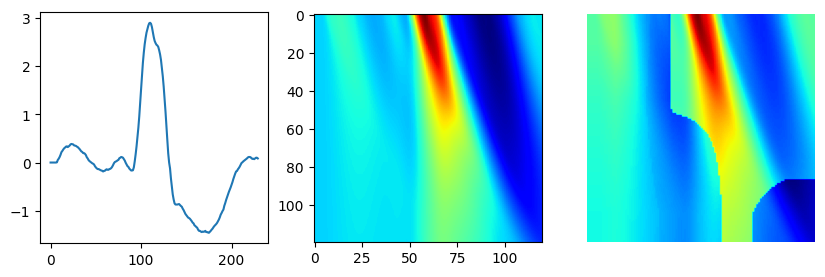

In [69]:
from matplotlib.pyplot import cm

iterator = iter(test_ds)
class_idx = 2
i=-1
beat_no = 30599 
while(i<beat_no):
    item=next(iterator)[0]
    i+=1

path = test_infos['x1'][beat_no]
print(path)
beat = read_beat(path)
# Example Usage:
target_layer = net.module_.conv3  # Specify the target convolutional layer
grad_cam = GradCam(skorch_net=net, target_layer=target_layer)

# Prepare inputs for Grad-CAM
sample_x1, sample_x2 = item['x1'], torch.tensor(item['x2']).to('cuda')  # Replace with a valid sample from your dataset

sample_x1 = sample_x1.unsqueeze(0).to('cuda')  # Add batch dimension
sample_x2 = sample_x2.unsqueeze(0).to('cuda')

# Generate Grad-CAM heatmap
heatmap = grad_cam.generate_heatmap({'x1': sample_x1, 'x2': sample_x2}, class_idx=class_idx)  # Replace with the desired class index

# Overlay and visualize
overlayed_image = GradCam.overlay_heatmap(sample_x1, heatmap, alpha=0.3)

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.plot(beat)
plt.subplot(132)
plt.imshow(item['x1'][0], cmap='jet')
plt.subplot(133)
plt.imshow(overlayed_image, cmap='jet')

plt.axis('off')
plt.show()